# 0) Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Note: To run this line, you may need to download the dataset and upload the CSV to your Colab Runtime.
# Data: https://www.kaggle.com/datasets/PromptCloudHQ/toy-products-on-amazon/data
amazon_data_raw = pd.read_csv('amazon_co-ecommerce_sample.csv')

In [4]:
amazon_data_raw.head()
print(amazon_data_raw.columns)

Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category',
       'customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers', 'customer_reviews', 'sellers'],
      dtype='object')


# 1) Data Exploration, Cleaning, and Preprocessing

In [5]:
# Preserve a copy of our raw data and create a variable to store our processed data:
amazon_data_processed = amazon_data_raw
# We should drop the ID column, as unique identifiers are generally generated in a manner uncorrelated with the underlying data
amazon_data_processed = amazon_data_processed.drop(columns=['uniq_id'])

### 1.1 Numeric Features

Preprocessing our numeric columns is a two step process:
- <b>Cleaning</b>: To clean our numeric columns, we strip any non-numeric data and convert to a numeric type.
- <b>Inputation</b>: Imputing missing values.

In [6]:
# Our dataset contains 5 numeric columns
numeric_columns = ["price", "number_available_in_stock", "number_of_reviews", "number_of_answered_questions", "average_review_rating"]

In [7]:
# Initially, most of our columns are parsed by default as strings, including columns which contain useful numerical data.
# We can start our data preprocessing by cleaning and casting these columns to numeric types.
print("Numeric Features by Type (Before Pre-Processing):")
amazon_data_raw[numeric_columns].dtypes

Numeric Features by Type (Before Pre-Processing):


price                            object
number_available_in_stock        object
number_of_reviews                object
number_of_answered_questions    float64
average_review_rating            object
dtype: object

In [8]:
# Simply convert number_of_reviews
amazon_data_processed['number_of_reviews'] =  pd.to_numeric(amazon_data_processed['number_of_reviews'].str.replace(',', ''))

In [9]:
# Simply convert number_of_answered_questions
amazon_data_processed['number_of_answered_questions'] = pd.to_numeric(amazon_data_processed['number_of_answered_questions'])

In [10]:
# Clean the "price" field by stripping leading '£' and all commmas
amazon_data_processed['price'] = amazon_data_processed['price'].str.replace('£', '')
amazon_data_processed['price'] = amazon_data_processed['price'].str.replace(',', '')

# Some prices include a range (Ex: 6.99 - 10.49), so we impute the average of the range:
for idx, value in amazon_data_processed['price'].items():
    if "-" in str(value):
        value_range = [float(match) for match in re.findall(r'\d+\.\d+', value)]
        average_value = sum(value_range) / len(value_range)
        amazon_data_processed.loc[idx, 'price'] = average_value

amazon_data_processed['price'] = pd.to_numeric(amazon_data_processed['price'])

In [11]:
# Clean the "average_review_rating" by stripping trailing text"
amazon_data_processed['average_review_rating'] = pd.to_numeric(amazon_data_raw['average_review_rating'].str.replace('out of 5 stars', ''))

In [12]:
# Strip descriptive strings about the quality of items in stock
amazon_data_processed['number_available_in_stock'] = amazon_data_processed['number_available_in_stock'].str.replace('new', '')
amazon_data_processed['number_available_in_stock'] = amazon_data_processed['number_available_in_stock'].str.replace('used', '')
amazon_data_processed['number_available_in_stock'] = amazon_data_processed['number_available_in_stock'].str.replace('collectible', '')
amazon_data_processed['number_available_in_stock'] = amazon_data_processed['number_available_in_stock'].str.replace('refurbished', '')
amazon_data_processed['number_available_in_stock'] = amazon_data_processed['number_available_in_stock'].str.strip()
amazon_data_processed['number_available_in_stock'] = pd.to_numeric(amazon_data_processed['number_available_in_stock'])

In [13]:
# For the remaining numeric columns, we can do a simple imputation using the median value:
for column_name in numeric_columns:
    median = amazon_data_processed[column_name].median()
    amazon_data_processed[column_name].fillna(median, inplace=True)

### 1.2 Categorical Features

In [14]:
# To process the amazon_category_and_sub_category we can use the parent category and impute the mode for missing samples,
# and drop the original column.
amazon_data_processed['category'] = amazon_data_raw['amazon_category_and_sub_category'].str.split(' > ').str[0]
amazon_data_processed['category'] = amazon_data_processed['category'].fillna(amazon_data_processed.mode()['category'][0])
amazon_data_processed = amazon_data_processed.drop(columns=['amazon_category_and_sub_category'])

In [15]:
# We can simply impute the mode for our 'manufacturer' column to account for missing data:
amazon_data_processed['manufacturer'] = amazon_data_processed['manufacturer'].fillna(amazon_data_processed.mode()['manufacturer'][0])

- <b>Cardinality of Categorical Featues:</b> We can see that there is high cardinality in our categorical values even by plotting just the top 20 of each category. We'll need to be careful to encode our categorical features without introducing too many dimensions.

In [16]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['category', 'manufacturer']
# One simple strategy to represent our categorical features without introducing
# too many extra dimensions is to cap the number of categories.
def process_categorical_variables(df, categorica_column_names, max_categories=20):
    encoder = OneHotEncoder(max_categories=max_categories)
    transformed_df = encoder.fit_transform(df[categorica_column_names])
    df[encoder.get_feature_names_out(categorica_column_names)] = transformed_df.toarray()
    return df.drop(columns=categorica_column_names, axis=1)

amazon_data_processed = process_categorical_variables(amazon_data_processed, categorical_features)



### 1.3 Text Features

In [17]:
# We can drop columns with significant missingness that cannot be imputed and contain little predictive value:
columns_to_drop = ['customer_questions_and_answers', 'sellers']

# Drop the missing columns
amazon_data_processed = amazon_data_processed.drop(columns=columns_to_drop)

In [18]:
# We can drop rows from columns with low levels of missingness but critical predictive value:
columns_to_keep = ['description', 'product_information', 'product_description', 'customer_reviews']
amazon_data_processed = amazon_data_processed.dropna(subset=columns_to_keep)

In [19]:

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import datetime

stemmer = PorterStemmer()

def process_text(text):
    # Convert to lowercase
    text = text.lower()
    # Strip special chars
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
    # Tokenize
    token_words = word_tokenize(text)
    # Strip stop words
    stripped_words = [word for word in token_words if word not in stopwords.words('english')]
    # Stem
    stemmed_text = [stemmer.stem(word) for word in stripped_words]
    # Join and return
    return " ".join(stemmed_text)


In [20]:

raw_text_colunmns = [ 'product_information', 'product_description']
# Process our text data
amazon_data_processed['raw_text'] = amazon_data_processed[raw_text_colunmns].agg(' '.join, axis=1)
amazon_data_processed['raw_text'] = amazon_data_processed['raw_text'].apply(process_text)


In [21]:
# Drop the original features
raw_text_colunmns = [ 'product_information', 'product_description']
amazon_data_processed = amazon_data_processed.drop(columns = ['customer_reviews','description'])

amazon_data_processed = amazon_data_processed.drop(columns=raw_text_colunmns)

**`Handling the Items to Recommend Categorical Variables`**

In [22]:
#Preprocessing the columns to make them more readable
amazon_data_processed['customers_who_bought_this_item_also_bought'].dropna(inplace = True)
amazon_data_processed['items_customers_buy_after_viewing_this_item'].dropna(inplace = True )

prefix_to_remove = 'http://www.amazon.co.uk/'

#Converting to string
amazon_data_processed['customers_who_bought_this_item_also_bought'] = amazon_data_processed['customers_who_bought_this_item_also_bought'].astype(str)
amazon_data_processed['items_customers_buy_after_viewing_this_item'] = amazon_data_processed['items_customers_buy_after_viewing_this_item'].astype(str)

#Removing prefix
amazon_data_processed['customers_who_bought_this_item_also_bought' ] = [data.replace(prefix_to_remove, '') for data in amazon_data_processed['customers_who_bought_this_item_also_bought' ]]
amazon_data_processed['items_customers_buy_after_viewing_this_item' ] = [data.replace(prefix_to_remove, '') for data in amazon_data_processed['items_customers_buy_after_viewing_this_item' ]]

#Replacing Dash
amazon_data_processed['customers_who_bought_this_item_also_bought' ] = [data.replace('-', ' ') for data in amazon_data_processed['customers_who_bought_this_item_also_bought' ]]
amazon_data_processed['items_customers_buy_after_viewing_this_item' ] = [data.replace('-', ' ') for data in amazon_data_processed['items_customers_buy_after_viewing_this_item' ]]



In [23]:
#Splitting the data for each item bought
amazon_data_processed['customers_who_bought_this_item_also_bought'] = amazon_data_processed['customers_who_bought_this_item_also_bought'].str.split('|')
amazon_data_processed['items_customers_buy_after_viewing_this_item'] = amazon_data_processed['items_customers_buy_after_viewing_this_item'].str.split('|')

# Explode the lists to create new rows
amazon_data_processed = amazon_data_processed.explode('customers_who_bought_this_item_also_bought')
amazon_data_processed = amazon_data_processed.explode('items_customers_buy_after_viewing_this_item')

# Reset index
amazon_data_processed.reset_index(drop=True, inplace=True)



In [24]:
#Dropping Na's
amazon_data_processed = amazon_data_processed.drop(amazon_data_processed[amazon_data_processed['items_customers_buy_after_viewing_this_item'].str.contains('nan')].index)
amazon_data_processed = amazon_data_processed.drop(amazon_data_processed[amazon_data_processed['customers_who_bought_this_item_also_bought'].str.contains('nan')].index)


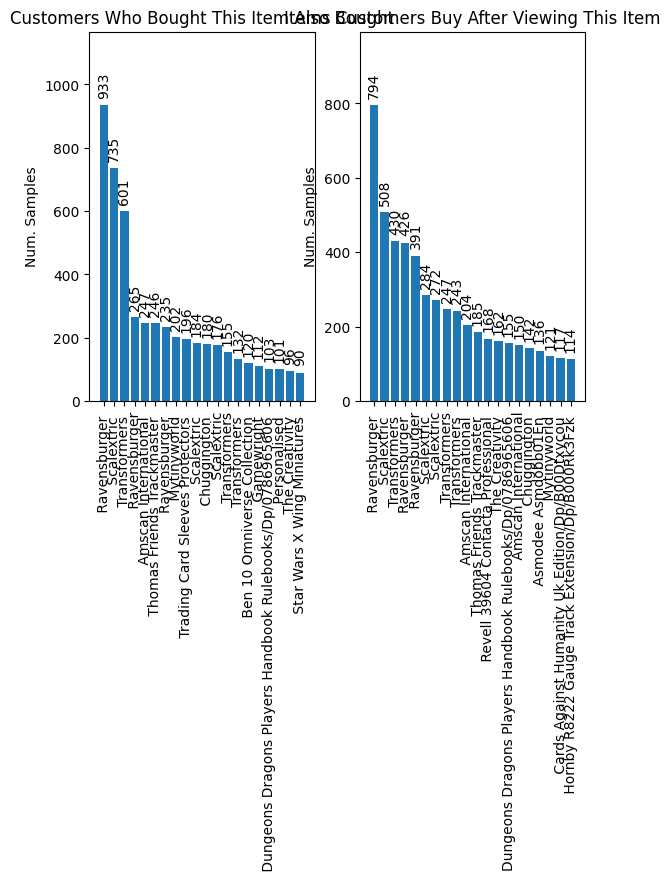

In [25]:
#Plotting the top 20 features
categorical_features = ['customers_who_bought_this_item_also_bought', 'items_customers_buy_after_viewing_this_item']


figure, axes = plt.subplots(1, 2, layout="constrained")


axes = axes.flatten()


for idx, column in enumerate(categorical_features):

    value_counts = amazon_data_processed[column].value_counts().nlargest(20)


    bars = axes[idx].bar(value_counts.keys(), value_counts.values)

    axes[idx].bar_label(bars, rotation=90, padding=5)
    axes[idx].set_ylabel('Num. Samples')
    axes[idx].set_title(column.title().replace("_", " "))

    formatted_keys = [category_name.title() for category_name in value_counts.keys()]
    axes[idx].set_xticks(value_counts.keys(), formatted_keys, rotation=90)


    axes[idx].set_ylim(0, max(value_counts.values) * 1.25)


plt.show()

In [26]:
#Since the two columns are so similar dropping the 'customers...' and analyzing further with the 'items....' column
value_count_items = 20
top_features = amazon_data_processed['items_customers_buy_after_viewing_this_item'].value_counts().nlargest(value_count_items).index
amazon_data_processed = amazon_data_processed[amazon_data_processed['items_customers_buy_after_viewing_this_item'].isin(top_features)]

# 2) Recommendation System Using Neural Networks



#### 1. Item to Item



In [27]:
import pandas as pd

df_x = amazon_data_processed.drop(['customers_who_bought_this_item_also_bought', 'items_customers_buy_after_viewing_this_item'], axis=1)
df_y = amazon_data_processed['items_customers_buy_after_viewing_this_item']



In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

from tensorflow.keras.utils import to_categorical


item_encoder = LabelEncoder()
df_x['item'] = item_encoder.fit_transform(df_x['product_name'])


dev_df_x, test_df_x, dev_df_y, test_df_y = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

train_df_x, val_df_x, train_df_y, val_df_y = train_test_split(dev_df_x, dev_df_y, test_size = 0.2, random_state = 42)

In [29]:
df_x['item']

120       145
124       145
128       145
132       145
136       145
         ... 
141728    260
141730    260
141731    260
141732    260
141734    260
Name: item, Length: 5249, dtype: int64

In [30]:
label_encoder = LabelEncoder()
train_df_y_encoded = label_encoder.fit_transform(train_df_y)
val_df_y_encoded = label_encoder.transform(val_df_y)
test_df_y_encoded = label_encoder.transform(test_df_y)

In [31]:
num_classes = value_count_items
train_df_y_one_hot = to_categorical(train_df_y_encoded, num_classes=num_classes)
val_df_y_one_hot = to_categorical(val_df_y_encoded, num_classes=num_classes)
test_df_y_one_hot = to_categorical(test_df_y_encoded, num_classes=num_classes)

model = Sequential()
model.add(Embedding(input_dim=len(item_encoder.classes_), output_dim=32))
model.add(SimpleRNN(32, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_df_x['item'].values.reshape(-1, 1), train_df_y_one_hot, epochs=12, batch_size=32, validation_data=(val_df_x['item'].values.reshape(-1, 1), val_df_y_one_hot))

test_loss, test_acc = model.evaluate(test_df_x['item'].values.reshape(-1, 1), test_df_y_one_hot)
print(f'Test accuracy: {test_acc}')

Epoch 1/12
105/105 [==============================] - 2s 4ms/step - loss: 2.9134 - accuracy: 0.1917 - val_loss: 2.7886 - val_accuracy: 0.2238
Epoch 2/12
105/105 [==============================] - 0s 2ms/step - loss: 2.4172 - accuracy: 0.3075 - val_loss: 2.0704 - val_accuracy: 0.3214
Epoch 3/12
105/105 [==============================] - 0s 2ms/step - loss: 1.6931 - accuracy: 0.4132 - val_loss: 1.5405 - val_accuracy: 0.5119
Epoch 4/12
105/105 [==============================] - 0s 2ms/step - loss: 1.2704 - accuracy: 0.6026 - val_loss: 1.1900 - val_accuracy: 0.6107
Epoch 5/12
105/105 [==============================] - 0s 2ms/step - loss: 0.9703 - accuracy: 0.6684 - val_loss: 0.9555 - val_accuracy: 0.6571
Epoch 6/12
105/105 [==============================] - 0s 2ms/step - loss: 0.7932 - accuracy: 0.6829 - val_loss: 0.8262 - val_accuracy: 0.6571
Epoch 7/12
105/105 [==============================] - 0s 2ms/step - loss: 0.7119 - accuracy: 0.6820 - val_loss: 0.7684 - val_accuracy: 0.6571
Epoch 

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          14560     
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 20)                660       
                                                                 
Total params: 17300 (67.58 KB)
Trainable params: 17300 (67.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


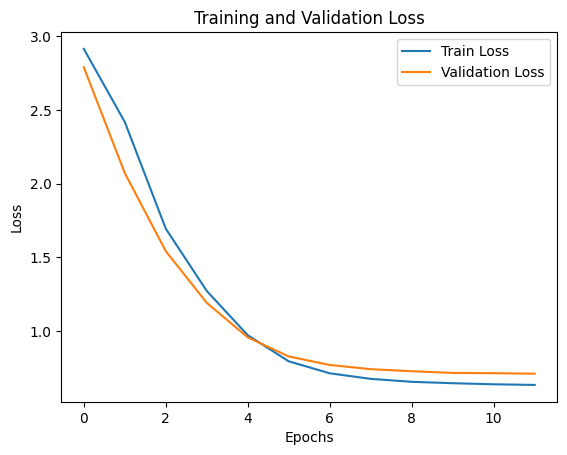

In [33]:
epochs = 10
# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

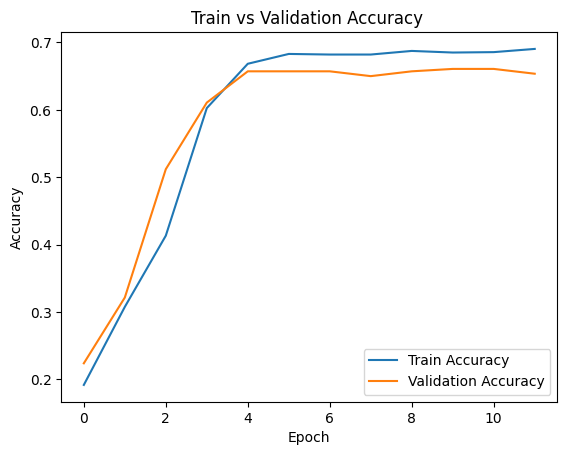

In [34]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy ')
plt.legend()
plt.show()

#### 2. Description to Item

In [35]:
#Importing Libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout


In [36]:

num_classes = value_count_items

# Preprocess text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_x['raw_text'])
sequences = tokenizer.texts_to_sequences(df_x['raw_text'])
X = pad_sequences(sequences)
vocab_size = len(tokenizer.word_index) + 1

#Encoding Y
label_encoder = LabelEncoder()
df_y_encoded = label_encoder.fit_transform(df_y)

y_categorical = to_categorical(df_y_encoded, num_classes=num_classes)

# Model
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=X.shape[1]))
model2.add(LSTM(100, return_sequences=True))
model2.add(Dropout(0.2))  # Adding dropout for regularization
model2.add(LSTM(50))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Training
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=23, validation_split=0.1)



Epoch 1/15
165/165 [==============================] - 93s 538ms/step - loss: 2.5250 - accuracy: 0.1789 - val_loss: 1.8576 - val_accuracy: 0.3786
Epoch 2/15
165/165 [==============================] - 87s 526ms/step - loss: 1.6645 - accuracy: 0.3800 - val_loss: 1.2979 - val_accuracy: 0.4786
Epoch 3/15
165/165 [==============================] - 85s 514ms/step - loss: 1.2777 - accuracy: 0.4459 - val_loss: 1.3109 - val_accuracy: 0.4619
Epoch 4/15
165/165 [==============================] - 85s 517ms/step - loss: 1.1277 - accuracy: 0.4948 - val_loss: 1.0319 - val_accuracy: 0.5000
Epoch 5/15
165/165 [==============================] - 87s 525ms/step - loss: 1.0018 - accuracy: 0.5382 - val_loss: 0.9815 - val_accuracy: 0.5357
Epoch 6/15
165/165 [==============================] - 86s 523ms/step - loss: 0.9794 - accuracy: 0.5523 - val_loss: 0.9018 - val_accuracy: 0.5881
Epoch 7/15
165/165 [==============================] - 86s 524ms/step - loss: 0.8682 - accuracy: 0.5941 - val_loss: 0.8679 - val_ac

In [37]:
# Evaluation
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


33/33 [==============================] - 4s 136ms/step - loss: 0.7136 - accuracy: 0.6505
Test accuracy: 0.6504762172698975


In [38]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 676, 32)           209152    
                                                                 
 lstm (LSTM)                 (None, 676, 100)          53200     
                                                                 
 dropout (Dropout)           (None, 676, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 25)               

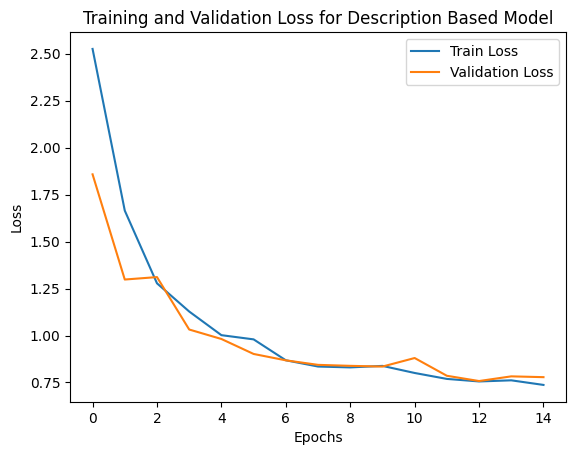

In [41]:
epochs = 15
# Plot training loss vs validation loss
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Description Based Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

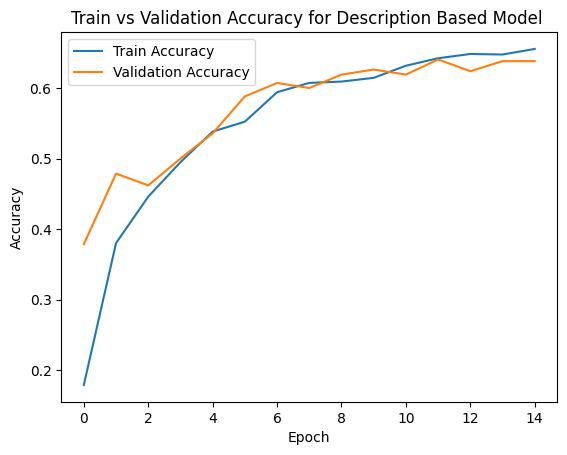

In [42]:

plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy for Description Based Model ')
plt.legend()
plt.show()